In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [3]:
import pickle
filename = 'C:\\Users\\Eliaz\\Documents\\GitHub\\Animal-identification-NN\\dataset\\raw-img\\datasetHSV.pkl'
df = pickle.load(open(filename, 'rb'))

In [4]:
working_df = df.copy()
working_df = working_df[np.isin(working_df['label'], ['cat', 'dog'])]
print(working_df['label'].value_counts())

dog    4863
cat    1668
Name: label, dtype: int64


In [5]:
print(working_df.columns)

Index(['label', 'img_hsv'], dtype='object')


In [6]:
#resize
size=80
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.resize(x, (size, size)))
print(working_df['img_hsv'].apply(lambda x: x.shape).unique().shape)

(1,)


In [7]:
#hsv to gray
# working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_HSV2RGB))
# working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY))

In [8]:
#img to array
print(working_df['img_hsv'].shape)
print(working_df['img_hsv'].iloc[0].shape)
print(type(working_df['img_hsv']))
print(type(working_df['img_hsv'].iloc[0]))
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: x.reshape(size, size, 3))
X = working_df['img_hsv'].values
X = np.stack(X)
print(X.shape)

(6531,)
(80, 80, 3)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(6531, 80, 80, 3)


In [9]:
#transforme le texte des labels en chiffres
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
working_df['label'] = le.fit_transform(working_df['label']) # 0 cat, 1 dog
print(working_df['label'].value_counts())

1    4863
0    1668
Name: label, dtype: int64


In [10]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, working_df['label'], test_size=0.2)


In [11]:
from tensorflow.keras.utils import to_categorical
num = 2
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)
print('turns',y_train.iloc[num],'into', train_Y_one_hot[num])

turns 1 into [0. 1.]


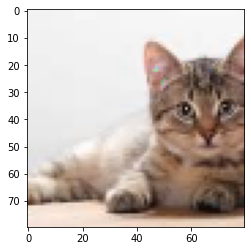

In [12]:
#impression image 
img = X[num]
rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
plt.imshow(rgb)

In [13]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [14]:
num_classes = train_Y_one_hot.shape[1]
print(num_classes)

2


In [33]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='linear',input_shape=(size,size,X.shape[3])))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='linear'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
#couche de sortie
model.add(Dense(num_classes, activation='softmax'))

In [34]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 76, 76, 32)        2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 20736)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [36]:
model.fit(X_train, train_Y_one_hot, batch_size=128, epochs=16, verbose=1, validation_data=(X_test, test_Y_one_hot))

Epoch 1/16
41/41 [==============================] - 24s 571ms/step - loss: 641.2661 - accuracy: 0.6344 - val_loss: 90.4453 - val_accuracy: 0.6993
Epoch 2/16
41/41 [==============================] - 23s 563ms/step - loss: 30.5409 - accuracy: 0.6943 - val_loss: 18.4860 - val_accuracy: 0.6067
Epoch 3/16
41/41 [==============================] - 23s 563ms/step - loss: 8.7149 - accuracy: 0.7504 - val_loss: 16.1765 - val_accuracy: 0.7123
Epoch 4/16
41/41 [==============================] - 24s 579ms/step - loss: 10.0922 - accuracy: 0.7473 - val_loss: 13.2954 - val_accuracy: 0.7345
Epoch 5/16
41/41 [==============================] - 24s 584ms/step - loss: 5.1825 - accuracy: 0.8099 - val_loss: 9.8763 - val_accuracy: 0.7001
Epoch 6/16
41/41 [==============================] - 24s 583ms/step - loss: 3.3841 - accuracy: 0.8375 - val_loss: 9.2002 - val_accuracy: 0.6679
Epoch 7/16
41/41 [==============================] - 24s 580ms/step - loss: 2.8361 - accuracy: 0.8536 - val_loss: 9.2619 - val_accuracy

Text(0.5, 0, 'epoch')

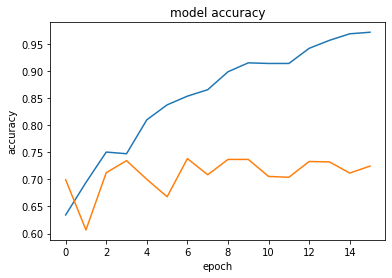

In [37]:
#graph accuracy vs val_accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

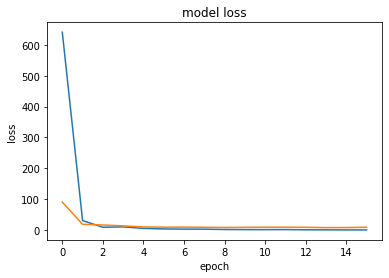

In [38]:
#graph loss vs val_loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [39]:
eval = model.evaluate(X_test, test_Y_one_hot, verbose=1)

41/41 [==============================] - 2s 41ms/step - loss: 8.8724 - accuracy: 0.7246
